In [22]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    return data

batch_files = [
    '../cifar-10-batches-py/data_batch_1',
    '../cifar-10-batches-py/data_batch_2',
    '../cifar-10-batches-py/data_batch_3',
    '../cifar-10-batches-py/data_batch_4',
    '../cifar-10-batches-py/data_batch_5'
]

all_data = []
all_labels = []

for file in batch_files:
    batch = unpickle(file)
    all_data.append(batch[b'data'])
    all_labels.extend(batch[b'labels'])


X = np.vstack(all_data)  # (50000, 3072)
y = np.array(all_labels) # (50000,)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (50000, 3072)
Shape of y: (50000,)


In [25]:
X = torch.tensor(X, dtype=torch.float).reshape(-1, 3, 32, 32)
y = torch.tensor(y, dtype=torch.long).reshape(-1)

In [26]:
train_x, dev_x, train_y, dev_y = train_test_split(X, y, test_size=0.1)
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(dev_x, dev_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [27]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3, 16, 4, 2, 1), # 32x32 x 16 output size - kernel + 2*padding/stride + 1? 32 - 4 30 / 2 = 15 + 1 = 16
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, 2, 1), # 8x8
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 4x4
            nn.ReLU(),
        )

        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1), # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 4, 2, 1), # 32 x 32
            nn.ReLU(),
        )
    def forward(self, x):
        return self.dec(self.enc(x))
model = Net()

In [28]:
X, y = next(iter(train_loader))

# print(model(X)[0])
y.shape

torch.Size([64])

In [71]:
def train_the_model():
    loss_fn = nn.L1Loss()
    model = Net()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    ep = 0
    for epoch in range(50):
        batch_losses = []
        batch_acc = []
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            yHat = model(X)
            loss = loss_fn(yHat, X)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # accuracy = (torch.argmax(yHat, dim=1) == y).float().sum()
            # batch_acc.append(accuracy.cpu() / y.shape[0])
            batch_losses.append(loss.item())
        train_acc.append(100*np.mean(batch_acc))
        train_loss.append(np.mean(batch_losses))

        with torch.no_grad():
            model.eval()
            X, y = next(iter(test_loader))
            X, y = X.to(device), y.to(device)
            yHat = model(X)
            loss = loss_fn(yHat, X)
            # accuracy = (torch.argmax(yHat, dim=1) == y).float().sum()
            # test_acc.append(100*accuracy.cpu() / y.shape[0])
            test_loss.append(loss.item())

        print("Epoch:", ep)
        ep += 1

    return model, train_acc, test_acc, train_loss, test_loss

In [72]:
model, train_acc, test_acc, train_loss, test_loss = train_the_model()

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49


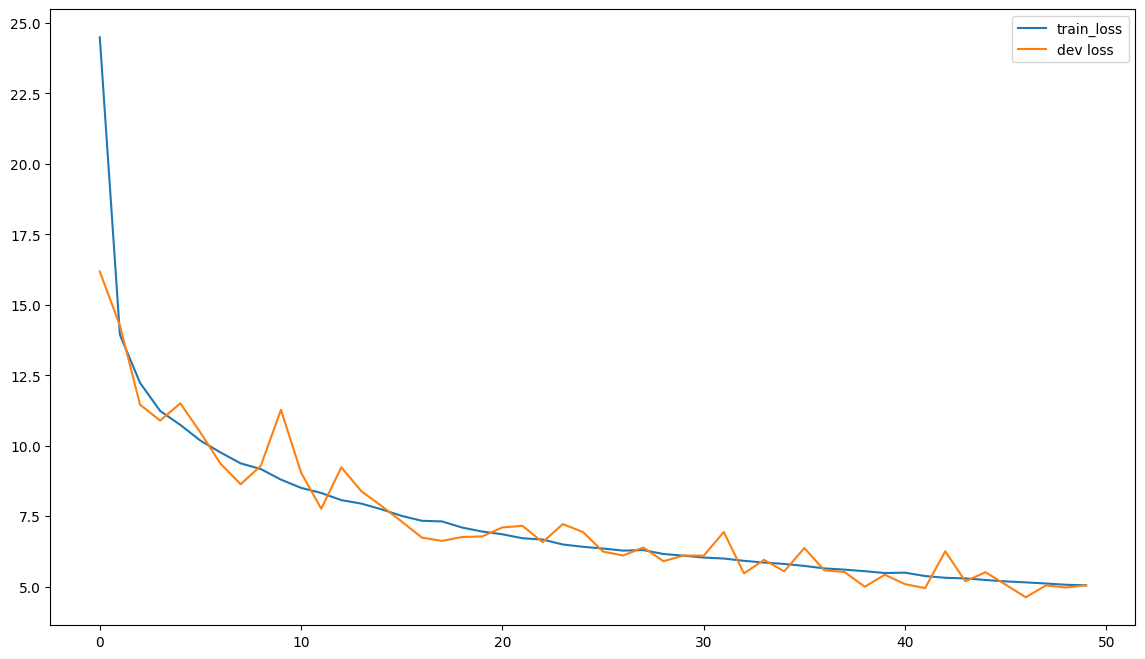

In [74]:
fig, ax = plt.subplots(ncols=1, figsize=(14, 8))
ax.plot(train_loss, label="train_loss")
ax.plot(test_loss, label="dev loss")
# ax.set_ylim([0, 70])
ax.legend()

In [75]:
labels_mapping = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck" ]

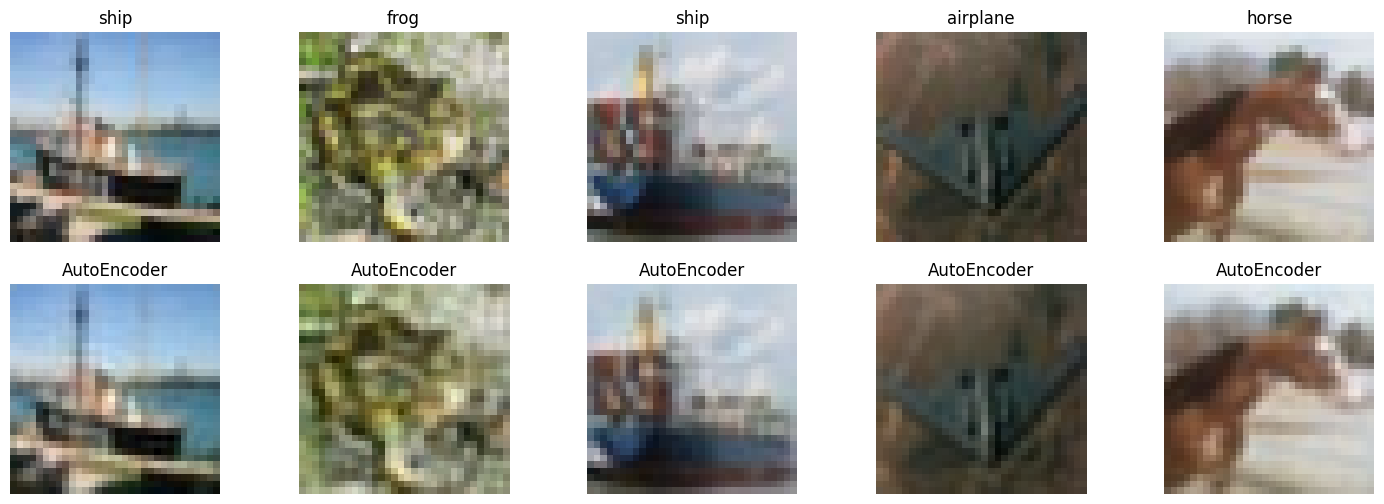

In [78]:

Xs = np.vstack(all_data)
ys = np.array(all_labels)
Xs = Xs[:1000]
ys = ys[:1000]
X_images = Xs.reshape(-1, 3, 32, 32)
X_images = np.transpose(X_images, (0, 2, 3, 1))

num_images = 10
random_indices = np.random.choice(Xs.shape[0], num_images, replace=False)

X = torch.tensor(Xs[:1000], dtype=torch.float, device=device).reshape(-1, 3, 32, 32)
y = torch.tensor(ys[:1000], dtype=torch.long, device=device).reshape(-1)

yHat = model(X[random_indices])
yHat = torch.clamp(yHat, 0, 255)
# Zakładając, że yHat to obrazy wygenerowane przez autoenkoder, nie przekształcamy ich do 32x32x3
yHat = yHat.cpu().detach().numpy()

fig, ax = plt.subplots(2, 5, figsize=(18, 6))
for i in range(5):
    ax[0][i].imshow(X_images[random_indices[i]].astype(np.uint8))
    ax[0][i].axis("off")
    ax[0][i].set_title(f"{labels_mapping[ys[random_indices[i]]]}")

    # Jeśli yHat jest obrazem w formacie (batch_size, 3, 32, 32), to przekształcamy do (32, 32, 3)
    ax[1][i].imshow(np.transpose(yHat[i], (1, 2, 0)).astype(np.uint8))
    ax[1][i].axis("off")
    ax[1][i].set_title(f"AutoEncoder")

plt.show()


In [58]:
yHat

array([[[[ 69.45564  ,  68.449524 ,  74.3334   ],
         [ 79.4734   ,  76.43332  ,  69.21461  ],
         [ 53.07137  ,  46.68358  ,  62.411373 ],
         ...,
         [ 32.39357  ,  44.475864 ,  41.524315 ],
         [ 34.319363 ,  45.055756 ,  56.68457  ],
         [ 55.324493 ,  36.698723 ,  27.310553 ]],

        [[ 70.11179  ,  64.22614  ,  68.932014 ],
         [ 67.31233  ,  63.81545  ,  66.67331  ],
         [ 62.029408 ,  56.469055 ,  61.256844 ],
         ...,
         [ 80.184135 ,  78.96803  ,  76.41576  ],
         [ 76.39357  ,  73.06218  ,  51.20341  ],
         [ 31.057741 ,  43.322914 ,  60.76457  ]],

        [[ 95.31012  , 134.26442  , 159.70511  ],
         [111.606895 ,  71.63982  ,  65.94756  ],
         [ 52.976868 ,  45.44794  ,  50.22972  ],
         ...,
         [ 50.515953 ,  60.22965  ,  73.814186 ],
         [ 59.07736  ,  55.52326  ,  72.96635  ],
         [ 61.571976 ,  40.78062  ,  42.567574 ]],

        ...,

        [[ 56.4771   ,  59.541183 ,  6